# MillenniumAI performance comparison

### Set executable paths

In [21]:
import sys
import networkx as nx
import matplotlib.pyplot as plt
import os
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
from torch_geometric.loader import NeighborLoader
import torch
import subprocess
from typing import Tuple, List, Dict
import socket
import time

# Necessary to import from sibling directory
sys.path.append("..")


from pymdb import (
    MDBClient,
    TrainGraphLoader,
    EvalGraphLoader,
    SamplingGraphLoader,
    Sampler,
)


In [22]:
# Path to MillenniumDB/MillenniumAI executables
SERVER_PYMDB_PATH = "/home/zeus/MDB/MillenniumDB-Dev/build/Release/bin/server_pymdb"
CREATE_DB_PATH = "/home/zeus/MDB/MillenniumDB-Dev/build/Release/bin/create_db"

if not os.path.exists(SERVER_PYMDB_PATH):
    raise Exception(
        "SERVER_PYMDB_PATH is not set to the correct path. "
        "Please set it to the path of the MillenniumDB server_pymdb executable."
    )

if not os.path.exists(CREATE_DB_PATH):
    raise Exception(
        "CREATE_DB_PATH is not set to the correct path. "
        "Please set it to the path of the MillenniumDB create_db executable."
    )

# Port to run MillenniumDB server on
SERVER_PORT = 8080

### Define performance test function

In [56]:
# Generate graphs in NetworkX and MillenniumDB format. Returns the in-memory graph and the path to the on-disk graph.
def generate_graph(
    num_nodes: int,
    num_edges: int,
    num_node_feat: int,
) -> Tuple[Data, str]:
    # In-memory graph
    graph = from_networkx(
        nx.gnm_random_graph(num_nodes, num_edges, seed=2023, directed=True)
    )
    graph.node_feat = torch.rand(num_nodes, num_node_feat, dtype=torch.float32)

    # On-disk MillenniumDB graph
    dump_path = f"N{num_nodes}_E{num_edges}_F{num_node_feat}.milldb"

    if os.path.exists(dump_path):
        print("Graph dump already exists. Skipping generation...")
        return graph, dump_path

    with open(dump_path, "w") as f:
        for idx in range(graph.num_nodes):
            f.write(f"N{idx} feat:{graph.node_feat[idx].tolist()}\n")
        for edge in graph.edge_index.T:
            f.write(f"N{edge[0]}->N{edge[1]} :T\n")
    return graph, dump_path


# Create a MillenniumDB database from a file in the current directory and return its path
def create_db(dump_path: str) -> str:
    dest_path = os.path.basename(dump_path).replace(".milldb", "")

    if os.path.isdir(dest_path):
        print("Database already exists. Skipping creation...")
        return dest_path

    result = subprocess.run(
        [CREATE_DB_PATH, dump_path, dest_path],
        stdout=subprocess.DEVNULL,
        stderr=subprocess.PIPE,
    )
    if result.returncode != 0:
        raise RuntimeError(f"create_db: {result.stderr.decode('utf-8')}")
    return dest_path


# Start a MillenniumDB server for a given database directory
def start_server(db_path: str):
    process = subprocess.Popen(
        [SERVER_PYMDB_PATH, db_path, "-p", str(SERVER_PORT)],
        stdout=subprocess.DEVNULL,
        stderr=subprocess.PIPE,
    )

    # Wait for server to listen to port
    while socket.socket().connect_ex(("localhost", SERVER_PORT)) != 0:
        time.sleep(0.5)

    return process


# Kill a MillenniumDB server process and return its exit code
def kill_server(process) -> int:
    process.kill()
    return process.wait()


# Define a function to compute the size of a graph (in MB)
def instance_size(instance: Dict) -> int:
    return (
        instance["num_nodes"] * 8
        + instance["num_node_feat"] * instance["num_nodes"] * 4
        + instance["num_edges"] * 8 * 2
    ) / 1e6


# Run performance tests for a list of instances and a list of batch sizes
def run_performance_tests(instances: List[Dict], batch_sizes: List[int]):
    generated_dumps = list()
    generated_dbs = list()
    plot_data = dict()

    for instance in instances:
        # Generate graphs and create database
        graph, dump_path = generate_graph(**instance)
        db_path = create_db(dump_path)

        generated_dumps.append(dump_path)
        generated_dbs.append(db_path)

        print(f"Running for instance: {instance}...")

        # Start MillenniumDB server
        server_process = start_server(db_path)

        plot_data[db_path] = {"mem": list(), "mdb": list(), "batch_size": list()}
        for batch_size in batch_sizes:
            plot_data[db_path]["batch_size"].append(batch_size)

            print(f"  Running for batch size: {batch_size}...")
            # 1. In-memory graph
            t0_mem = time.perf_counter_ns()
            for batch in NeighborLoader(
                graph, num_neighbors=[5, 5], batch_size=batch_size
            ):
                # Here the batch would be passed to a model
                pass
            plot_data[db_path]["mem"].append((time.perf_counter_ns() - t0_mem) / 1e9)

            # 2. MillenniumDB graph
            # Connect to server
            with MDBClient("localhost", SERVER_PORT) as client:
                t0_mdb = time.perf_counter_ns()
                for batch in EvalGraphLoader(
                    client, num_neighbors=[5, 5], batch_size=batch_size
                ):
                    # Here the batch would be passed to a model
                    pass
                plot_data[db_path]["mdb"].append(
                    (time.perf_counter_ns() - t0_mdb) / 1e9
                )

        # Clean up
        kill_server(server_process)
        subprocess.run(["rm", dump_path])
        subprocess.run(["rm", "-rf", db_path])

    return plot_data


### Run performance tests for instances

In [61]:
instances = [
    {"num_nodes": 100, "num_edges": 1_000, "num_node_feat": 100},
    {"num_nodes": 1_000, "num_edges": 10_000, "num_node_feat": 100},
    {"num_nodes": 10_000, "num_edges": 10_000, "num_node_feat": 100},
    {"num_nodes": 1_000_000, "num_edges": 10_000, "num_node_feat": 100},
]
sizes = [instance_size(instance) for instance in instances]
args = {"instances": instances, "batch_sizes": [50, 100, 500, 750, 1000]}

plot_data = run_performance_tests(**args)


Running for instance: {'num_nodes': 100, 'num_edges': 1000, 'num_node_feat': 100}...
  Running for batch size: 50...
  Running for batch size: 100...
  Running for batch size: 500...
  Running for batch size: 750...
  Running for batch size: 1000...
Running for instance: {'num_nodes': 1000, 'num_edges': 10000, 'num_node_feat': 100}...
  Running for batch size: 50...
  Running for batch size: 100...
  Running for batch size: 500...
  Running for batch size: 750...
  Running for batch size: 1000...
Running for instance: {'num_nodes': 10000, 'num_edges': 10000, 'num_node_feat': 100}...
  Running for batch size: 50...
  Running for batch size: 100...
  Running for batch size: 500...
  Running for batch size: 750...
  Running for batch size: 1000...
Running for instance: {'num_nodes': 1000000, 'num_edges': 10000, 'num_node_feat': 100}...
  Running for batch size: 50...
  Running for batch size: 100...
  Running for batch size: 500...
  Running for batch size: 750...
  Running for batch size

In [62]:
def plot_comparison(x: List, y1: List, y2: List, x_label: str, y_label: str, title: str):
    plt.plot(x, y1, label="In-memory")
    plt.plot(x, y2, label="MillenniumDB")
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

In [64]:
print(plot_data)

{'N100_E1000_F100': {'mem': [0.001766031, 0.000885504, 0.00093269, 0.000731648, 0.000779487], 'mdb': [1.00840584, 0.498920801, 0.100579098, 0.051552379, 0.048911587], 'batch_size': [50, 100, 500, 750, 1000]}, 'N1000_E10000_F100': {'mem': [0.006390052, 0.009411365, 0.003751488, 0.001870457, 0.002265646], 'mdb': [1.006200811, 0.501342206, 0.096615263, 0.096823959, 0.050659364], 'batch_size': [50, 100, 500, 750, 1000]}, 'N10000_E10000_F100': {'mem': [0.022414502, 0.017864187, 0.007285064, 0.005363174, 0.005092202], 'mdb': [0.994648722, 0.502239483, 0.053886768, 0.046809696, 0.054235104], 'batch_size': [50, 100, 500, 750, 1000]}, 'N1000000_E10000_F100': {'mem': [7.031484436, 4.323382602, 1.280097041, 1.295663359, 0.73374506], 'mdb': [2.082220486, 1.261954626, 96.349233246, 66.663908576, 49.996018384], 'batch_size': [50, 100, 500, 750, 1000]}}


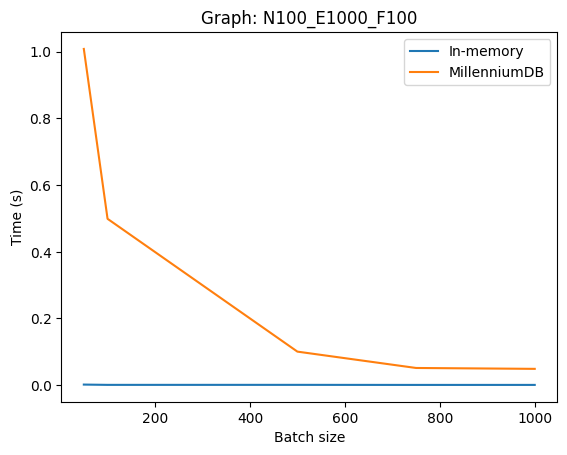

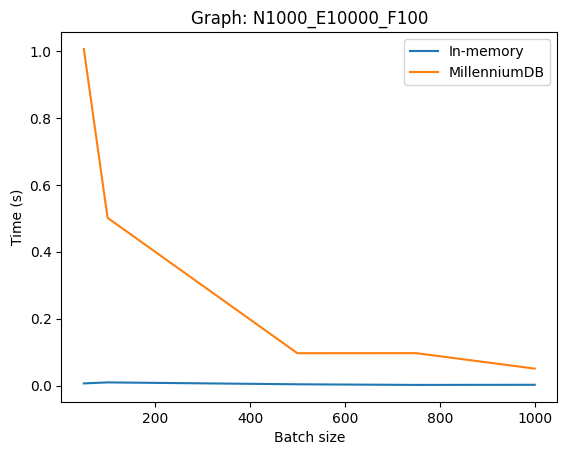

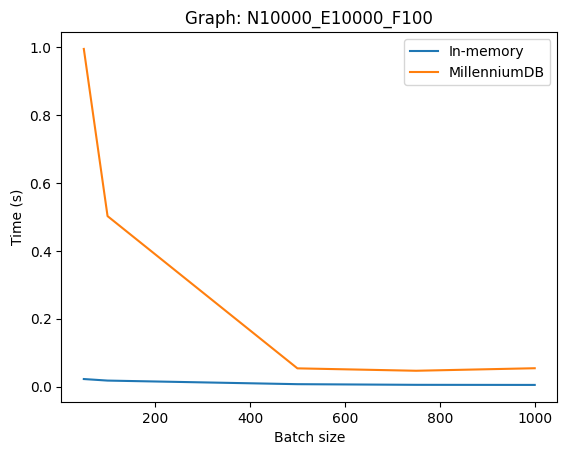

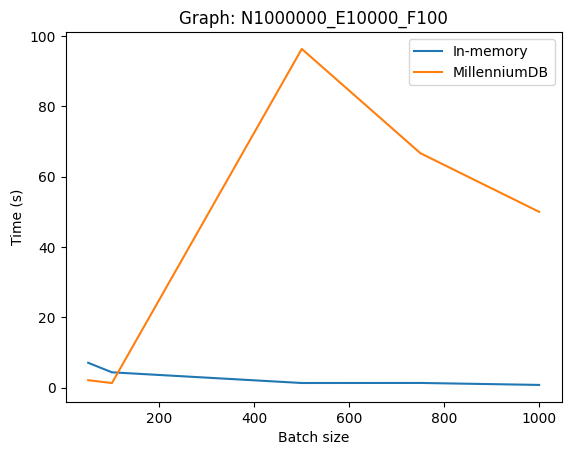

In [63]:
# Compare time over graph size
for graph_name, data in plot_data.items():
    plot_comparison(
        data["batch_size"],
        data["mem"],
        data["mdb"],
        "Batch size",
        "Time (s)",
        f"Graph: {graph_name}",
    )